In [79]:
import pandas as pd
import numpy as np

# 基于协方差法进行主成分分析
dataset = pd.read_table('./datas/例5-1.txt',index_col=0,sep='\t')
labels = dataset.columns
# 计算指标之间的协方差矩阵 Covariance Matrix
cov_mat = np.cov(dataset, rowvar=False)

各变量的量纲差别不大时，可以选择从协方差阵出发求解主成分， 这样可以更多的保留各变量自身的变异。

In [80]:
# 计算特征值和特征向量
eig_value, eig_vector = np.linalg.eig(cov_mat)
# 将特征值与特征向量对应起来，并对其进行排序
eigdf = pd.DataFrame(eig_vector.T).join(pd.DataFrame(eig_value, dtype=float, columns=["eig_value"]))
eigdf.index = labels
eigdf = eigdf.sort_values("eig_value")[::-1]
eigdf['cumlam'] = eigdf['eig_value'].apply(lambda x: x/eigdf['eig_value'].sum())
eigdf['ccve'] = eigdf['cumlam'].cumsum()
eigdf[['eig_value','cumlam','ccve']]

,eig_value,cumlam,ccve
X1,7.683653e+08,0.823020,0.823020
X2,8.268525e+07,0.088567,0.911587
X3,2.924922e+07,0.031330,0.942916
X4,1.721586e+07,0.018440,0.961357
X5,1.429627e+07,0.015313,0.976670
X7,7.511072e+06,0.008045,0.984715
X9,6.169207e+06,0.006608,0.991323
X8,5.030735e+06,0.005389,0.996712
X6,3.069824e+06,0.003288,1.000000


特征值$\lambda_i$的含义是$Y_k$的方差贡献率，代表着$Y_k$综合$\mathbf{X}$信息的能力。这里可以说

第一主成分的方差贡献率为82.302%，是保留的特征根占所有特征根的和的比值，可见第一主成分解释原始变量总差异的效果比较好。
第二主成分的方差贡献率为8.857%，这个相对第一主成分贡献率低很多。可以选择1个或两个，这里选择两个。
第一主成分与第二主成分的和称为累计贡献率，代表着$Y_1$和$Y_2$总共能代表$\mathbf{X}$的多少信息，可以看到我们选择的主成分打开可以解释原矩阵91.159%的信息。

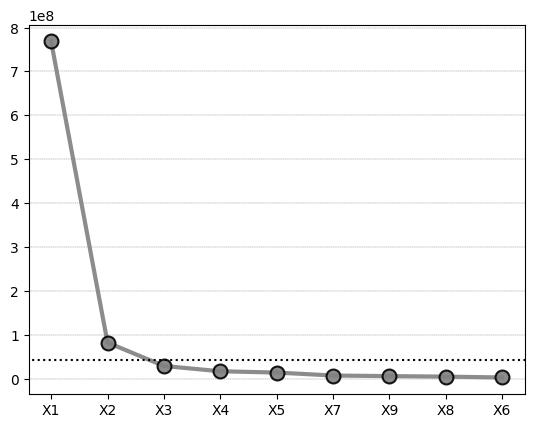

In [81]:
import matplotlib.pyplot as plt
eigdf['eig_value'].plot(linestyle='-', linewidth=3, color='grey', marker = "o",markeredgecolor='k',alpha=0.9,markersize='10',markeredgewidth=1.5)
plt.grid(ls = "--",axis='y', lw = 0.25, color = "#4E616C")
plt.axhline(y=8.268525e+07-4e7, xmin=-1, xmax=10, color='black', linestyle=':')
plt.show()

In [82]:
# 主成分特征向量
# 获取与特征值对应的特征向量（排序后）
eig_vector = eigdf.iloc[:, :9].T
n_pcl = 2
pcl_vector = eig_vector.iloc[:, :n_pcl]
print(f'前{n_pcl}个主成分：')
for i in range(pcl_vector.shape[1]):
    k = pcl_vector.iloc[:, i]
    ss = [f'{k[j]:+.3f}' + f'*X{j+1}' for j in range(len(k))]
    print(f'Y{i+1}={"".join(ss) if "".join(ss).startswith("-") else "".join(ss)[1:]}')

pcl_vector

前2个主成分：
Y1=-0.119*X1-0.232*X2-0.169*X3-0.145*X4-0.130*X5-0.744*X6-0.409*X7-0.253*X8-0.283*X9
Y2=-0.320*X1-0.357*X2-0.353*X3-0.384*X4-0.275*X5+0.511*X6+0.074*X7-0.123*X8-0.375*X9


,X1,X2
0,-0.119186,-0.319971
1,-0.232096,-0.356935
2,-0.169432,-0.353153
3,-0.145298,-0.384201
4,-0.130296,-0.275462
5,-0.743832,0.510641
6,-0.409132,0.073737
7,-0.253333,-0.123219
8,-0.283334,-0.375013


所谓的主成分就是$Y_i=\gamma_i^T\mathbf{X}$，所谓的$\gamma_i^T$就是我们的特征向量的转置，我们取前两个特征向量即可。

In [83]:
# 计算因子载荷矩阵
# 取出前两个特征值，开方后，将其对角化
eigmat = np.diag(np.sqrt(eig_value[:n_pcl]))
# 特征向量分别矩阵乘 对角化矩阵
gamma = pcl_vector.dot(eigmat)
sigma = np.sqrt(np.diag(cov_mat))
# 载荷矩阵
loadings = (gamma.T/sigma).T
loadings

,0,1
0,-0.647873,-0.570564
1,-0.846992,-0.427297
2,-0.659039,-0.450619
3,-0.663666,-0.575677
4,-0.736866,-0.511033
5,-0.971731,0.218835
6,-0.932051,0.055105
7,-0.909904,-0.145181
8,-0.875783,-0.380255


因子载荷含义为主成分$Y_j$与原始变量$X_i$的相关系数，$\rho(Y_k,X_i)=\frac{\gamma_{ik}\sqrt{\lambda_k}}{\sqrt{\sigma_{ii}}}$，这里我们先计算了特征向量与开方特征值的乘积$\gamma_{ik}\sqrt{\lambda_k}$，后续除以$\sqrt{\sigma_{ii}}$，它就是原矩阵协方差阵的对角线元素。

进一步思考因子载荷的意义，首先竖着来看，竖着各个元素平方后乘以$\sigma_{ii}$ 求和 就又算回了特征值，所以竖着看代表着 $Y_i$承载$\mathbf{X}$信息的能力。

横着来看，$(-0.64)^2$表示$X_1$对$Y_1$的贡献，$(-0.57)^2$表示$X_1$对$Y_2$的贡献，$(-0.64)^2+(-0.57)^2$代表$X_1$对主成分的合计贡献。因此因子负荷量的绝对值反映了$X_i$对$Y_k$的重要程度，刻画了原始变量对某主成分的主要意义及其贡献程度。

从第一主成分对应的因子负荷量可看到，X6-9在第一主成分中占较大比重，说明第一主成分主要综合了第三产业的就业人员的工资水平。第二主成分对应的因子负荷量主要是X6、X7和X8比较少，其他相差不多。

In [84]:
# 如下矩阵分别反映了X1-9对主成分1-2的贡献，横竖求和各具备不同的含义。
# 贡献率矩阵
VV = np.square(loadings)
# print(f"该主成分占所有主成分对原始变量方差贡献率总和之比：{np.sum(np.array(VV))/9:.3%}")
VV

,0,1
0,0.419740,0.325543
1,0.717396,0.182583
2,0.434332,0.203057
3,0.440452,0.331404
4,0.542972,0.261155
5,0.944261,0.047889
6,0.868719,0.003037
7,0.827926,0.021078
8,0.766995,0.144593


In [85]:
# 计算主成分得分
# pcl_vector['X1'] = -pcl_vector['X1']
X  = dataset - np.mean(dataset, axis=0)
X.values.dot(pcl_vector)

array([[-118622.1093543 ,   19739.07350328],
       [ -38460.51631757,  -12711.95922932],
       [  10753.51806511,     546.82038526],
       [  25527.52651574,   12637.43874525],
       [   9683.99650392,    1015.10787849],
       [  18743.80456396,    4736.82380165],
       [  23126.63376966,   14505.88779769],
       [  23499.15330846,   10402.80369609],
       [ -23058.70028996,     632.57588673],
       [  -8764.36755364,  -13749.02657475],
       [  -9842.50415229,  -12287.57409816],
       [   5346.54932648,    1458.22881606],
       [  -8227.82933804,    1279.30377552],
       [  10724.1019565 ,    1848.40324513],
       [ -20483.76168254,  -18902.61325532],
       [  21267.77827599,    2717.07683755],
       [  14401.38397023,    7477.41950273],
       [   6966.90703621,    5667.42887343],
       [  -7661.34269948,  -16035.11901933],
       [   9559.4314989 ,    5651.42746027],
       [  -1632.22003288,    2815.67791257],
       [ -24554.781019  ,   -5871.82271412],
       [  

In [1]:
import pandas as pd
import numpy as np

# 从相关矩阵出发进行主成分分析
dataset = pd.read_table('./datas/例5-1.txt', index_col=0, sep='\t')
labels = dataset.columns
# 计算相关矩阵Correlation Matrix
cor_mat = np.corrcoef(dataset, rowvar=False)
# 和标注化后的协方差矩阵对比一下
Xscale = (dataset - np.mean(dataset, axis=0)) / np.std(dataset, axis=0)
cov_mat_z = np.cov(Xscale, rowvar=False)

二者大致相似，但还是存在一点不同的，对于**度量单位不同的指标或取值范围彼此差异非常大**的指标，考虑使用标准化后的协方差矩阵求解，或者从相关阵开始求解。

In [6]:
# 简单对比一下二者特征值
eig_value_z, eig_vector_z = np.linalg.eig(cov_mat_z)
eig_value, eig_vector = np.linalg.eig(cov_mat_z)
# eig_value, eig_vector = np.linalg.eig(cor_mat)
print(eig_value_z)
print(eig_value)
# 二者特征值也不一样，而且都与为标准化矩阵不一样。

[6.96812952 0.85056188 0.46885192 0.31537164 0.2949448  0.17775926
 0.0575885  0.08167842 0.09545889]
[6.96812952 0.85056188 0.46885192 0.31537164 0.2949448  0.17775926
 0.0575885  0.08167842 0.09545889]


In [7]:
# 将特征值与特征向量对应起来，并对其进行排序
eigdf = pd.DataFrame(eig_vector.T).join(pd.DataFrame(eig_value, dtype=float, columns=["eig_value"]))
eigdf.index = labels
eigdf = eigdf.sort_values("eig_value")[::-1]
eigdf['cumlam'] = eigdf['eig_value'].apply(lambda x: x/eigdf['eig_value'].sum())
eigdf['ccve'] = eigdf['cumlam'].cumsum()
eigdf[['eig_value','cumlam','ccve']]

,eig_value,cumlam,ccve
X1,6.968130,0.748429,0.748429
X2,0.850562,0.091357,0.839785
X3,0.468852,0.050358,0.890144
X4,0.315372,0.033873,0.924017
X5,0.294945,0.031679,0.955696
X6,0.177759,0.019093,0.974789
X9,0.095459,0.010253,0.985042
X8,0.081678,0.008773,0.993815
X7,0.057588,0.006185,1.000000


In [8]:
# 主成分特征向量
# 获取与特征值对应的特征向量（排序后）
eig_vector = eigdf.iloc[:, :dataset.shape[1]].T
n_pcl = 2
pcl_vector = eig_vector.iloc[:, :n_pcl]
print(f'前{n_pcl}个主成分：')
for i in range(pcl_vector.shape[1]):
    k = pcl_vector.iloc[:, i]
    ss = [f'{k[j]:+.3f}' + f'*X{j+1}' for j in range(len(k))]
    print(f'Y{i+1}={"".join(ss) if "".join(ss).startswith("-") else "".join(ss)[1:]}')

pcl_vector

前2个主成分：
Y1=0.317*X1+0.363*X2+0.295*X3+0.318*X4+0.340*X5+0.319*X6+0.329*X7+0.349*X8+0.365*X9
Y2=0.395*X1+0.118*X2+0.237*X3+0.384*X4+0.199*X5-0.565*X6-0.441*X7-0.272*X8-0.020*X9


,X1,X2
0,0.316664,0.394507
1,0.362564,0.118398
2,0.294854,0.237341
3,0.317571,0.383605
4,0.339904,0.198848
5,0.318860,-0.564608
6,0.328993,-0.440709
7,0.348864,-0.271859
8,0.365146,-0.020219


In [9]:
# 计算因子载荷矩阵
# 取出前两个特征值，开方后，将其对角化
eigmat = np.diag(np.sqrt(eig_value[:n_pcl]))
# 特征向量分别矩阵乘 对角化矩阵
loadings = pcl_vector.dot(eigmat)
# 载荷矩阵
loadings

,0,1
0,0.835906,0.363838
1,0.957069,0.109194
2,0.778333,0.218890
3,0.838300,0.353784
4,0.897252,0.183389
5,0.841701,-0.520714
6,0.868450,-0.406448
7,0.920903,-0.250724
8,0.963883,-0.018648


由于$\sigma_{ii}=1$，因子载荷等价于：$\rho(Y_k,Z_i)=\gamma_{ik}\sqrt{\lambda_k}$，所求的特征向量，loadings及主成分得分同上也有所区别。

In [50]:
Xscale.values.dot(pcl_vector)

array([[ 8.46338640e+00, -3.27245648e+00],
       [ 4.62470701e+00,  5.58678777e-01],
       [-9.26364070e-01,  1.10781900e-02],
       [-3.67992520e+00, -8.11217892e-01],
       [-9.49407006e-01,  5.15467986e-01],
       [-2.15154910e+00, -1.04698977e-01],
       [-3.50203989e+00, -1.28843376e+00],
       [-3.13013101e+00, -5.16332908e-01],
       [ 1.98398631e+00, -5.88537476e-01],
       [ 2.21012302e+00,  1.06872374e+00],
       [ 2.25634250e+00,  1.16399211e+00],
       [-5.63626777e-01,  2.22275549e-01],
       [ 7.31948882e-01,  5.38430796e-01],
       [-1.28438678e+00, -2.61397312e-01],
       [ 4.01887743e+00,  1.78243172e+00],
       [-2.03063403e+00, -1.82972207e-01],
       [-2.03048411e+00, -4.69520491e-01],
       [-1.09307044e+00, -5.11787204e-01],
       [ 2.28053424e+00,  7.51463248e-01],
       [-1.47036273e+00, -2.26820162e-01],
       [ 4.04829168e-03, -2.72592485e-01],
       [ 2.74887680e+00,  4.56299022e-01],
       [-4.84147739e-01, -3.02053981e-02],
       [-7.

In [1]:
# 目前可以实现主成分分析的方法有很多，这里以sklearn 中的PCA为例
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
# 从相关矩阵出发进行主成分分析
dataset = pd.read_table('./datas/例5-1.txt', index_col=0, sep='\t')
labels = dataset.columns
Xscale = (dataset - np.mean(dataset, axis=0)) / np.std(dataset, axis=0)
# Xscale = dataset
pca = PCA(n_components=Xscale.shape[1])
pca.fit(Xscale)
# 查看特征值：
print(f'特征值：\n{pca.explained_variance_}')
print('这里的结果与基于标准化后的协方差的计算结果一致')
print(f'方差贡献率:\n{pca.explained_variance_ratio_}')

特征值：
[6.96812952 0.85056188 0.46885192 0.31537164 0.2949448  0.17775926
 0.09545889 0.08167842 0.0575885 ]
这里的结果与基于标准化后的协方差的计算结果一致
方差贡献率:
[0.74842873 0.09135665 0.05035817 0.03387325 0.03167926 0.01909266
 0.01025299 0.00877287 0.00618543]


In [6]:
# 确定保留两个主成分
n_components=2
# pca.components_
print(f'特征向量：\n{pca.components_.T[:,:n_components]}')
# 查看特征向量：同样与基于协方差的一致
# 计算因子载荷
# pcl_vector = eig_vector.iloc[:, :n_pcl]
eigmat = np.diag(np.sqrt(pca.explained_variance_[:n_components]))
# 特征向量分别矩阵乘 对角化矩阵
loadings = (pca.components_.T[:,:n_components]).dot(eigmat)
loadings

特征向量：
[[ 0.31666448 -0.39450707]
 [ 0.36256429 -0.1183979 ]
 [ 0.2948543  -0.23734085]
 [ 0.31757129 -0.38360546]
 [ 0.33990407 -0.19884783]
 [ 0.31885986  0.56460752]
 [ 0.32899311  0.44070884]
 [ 0.34886367  0.27185855]
 [ 0.36514579  0.02021943]]


array([[ 0.83590603, -0.36383774],
       [ 0.95706875, -0.10919354],
       [ 0.77833323, -0.21888976],
       [ 0.83829976, -0.35378363],
       [ 0.89725207, -0.18338922],
       [ 0.84170123,  0.52071443],
       [ 0.86845017,  0.40644775],
       [ 0.92090293,  0.25072403],
       [ 0.96388318,  0.01864755]])

In [7]:
# 主成分得分；得分也是相同的
pca.transform(Xscale)[:,:n_components]

array([[ 8.46338640e+00,  3.27245648e+00],
       [ 4.62470701e+00, -5.58678777e-01],
       [-9.26364070e-01, -1.10781900e-02],
       [-3.67992520e+00,  8.11217892e-01],
       [-9.49407006e-01, -5.15467986e-01],
       [-2.15154910e+00,  1.04698977e-01],
       [-3.50203989e+00,  1.28843376e+00],
       [-3.13013101e+00,  5.16332908e-01],
       [ 1.98398631e+00,  5.88537476e-01],
       [ 2.21012302e+00, -1.06872374e+00],
       [ 2.25634250e+00, -1.16399211e+00],
       [-5.63626777e-01, -2.22275549e-01],
       [ 7.31948882e-01, -5.38430796e-01],
       [-1.28438678e+00,  2.61397312e-01],
       [ 4.01887743e+00, -1.78243172e+00],
       [-2.03063403e+00,  1.82972207e-01],
       [-2.03048411e+00,  4.69520491e-01],
       [-1.09307044e+00,  5.11787204e-01],
       [ 2.28053424e+00, -7.51463248e-01],
       [-1.47036273e+00,  2.26820162e-01],
       [ 4.04829168e-03,  2.72592485e-01],
       [ 2.74887680e+00, -4.56299022e-01],
       [-4.84147739e-01,  3.02053981e-02],
       [-7.

总结：PCA函数完全基于协方差的方式求解主成分，但是在计算主成分最终得分时，选择先减去均值，我不知着为什么。